In [1]:
import pandas as pd
import numpy as np
import missingno as mn
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam
%matplotlib inline

In [2]:
# load data
raw = pd.read_csv('../arima_fc/data/canola_oil_v2.csv')
raw.index = pd.to_datetime(raw.date).dt.date

In [3]:
raw.head()

,date,co,co_prod,co_domestic,ca_canola_crush,ca_co_exports,cent_ill_sbo
date,,,,,,,
2000-01-01,2000-01-01,NaN,NaN,NaN,273.365,78.335,15.56
2000-02-01,2000-02-01,NaN,NaN,NaN,231.914,98.451,15.09
2000-03-01,2000-03-01,NaN,NaN,NaN,301.705,87.800,16.22
2000-04-01,2000-04-01,NaN,NaN,NaN,205.655,81.074,17.52
2000-05-01,2000-05-01,NaN,NaN,NaN,265.540,61.784,16.75


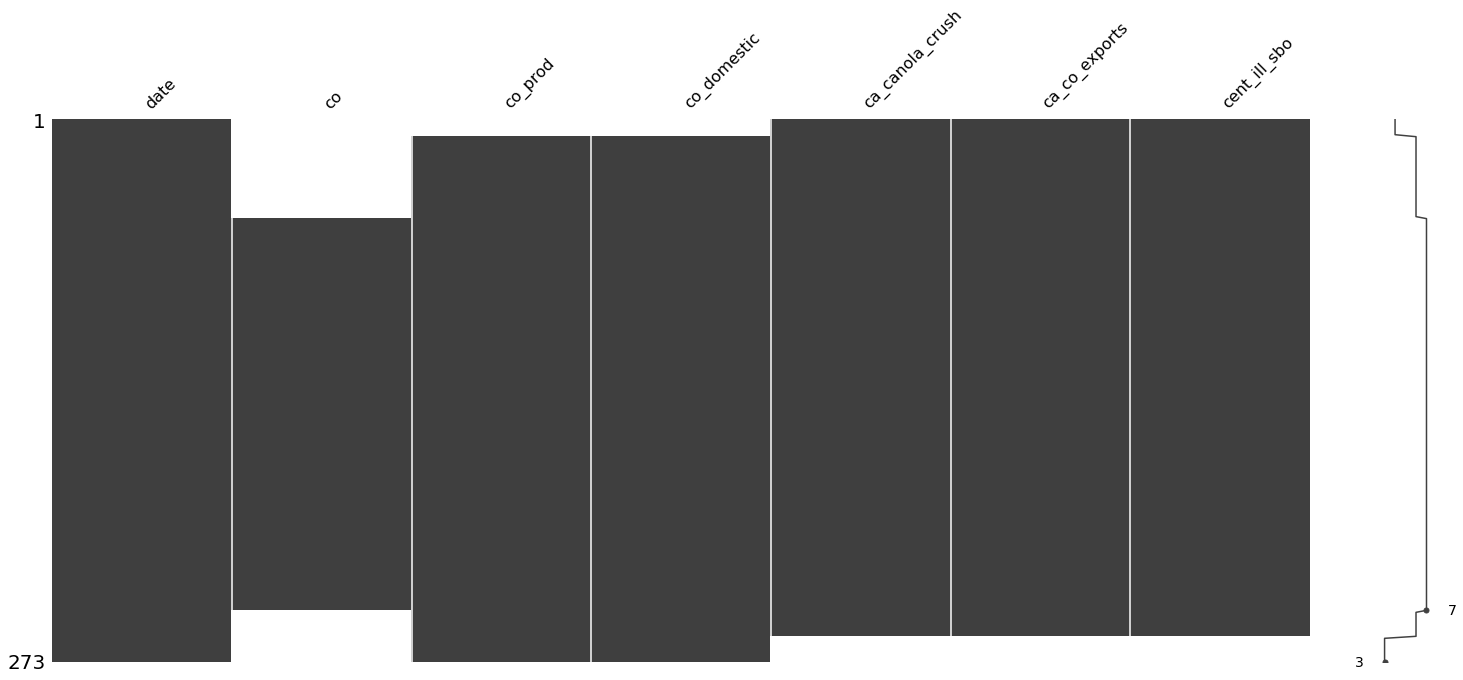

In [4]:
mn.matrix(raw)

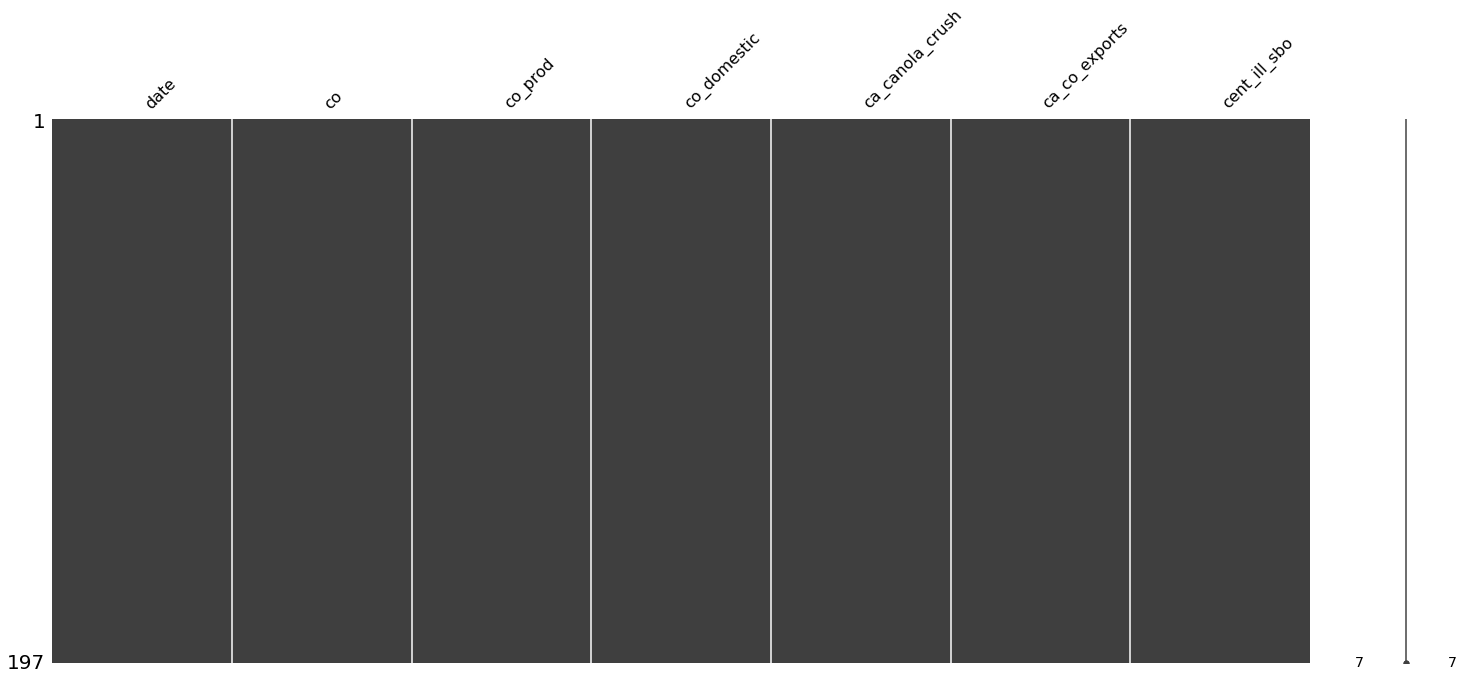

In [5]:
mn.matrix(raw[raw.co.notnull()])
df = raw[raw.co.notnull()]


In [6]:
df = df.drop('date',axis=1)
df.head()

,co,co_prod,co_domestic,ca_canola_crush,ca_co_exports,cent_ill_sbo
date,,,,,,
2004-03-01,40.39,24.0,91.0,325.247,97.685,34.66
2004-04-01,39.85,53.0,152.0,307.567,110.618,34.19
2004-05-01,38.00,56.0,108.0,288.000,105.372,32.68
2004-06-01,35.32,40.0,58.0,234.607,68.013,30.08
2004-07-01,33.98,56.0,228.0,306.664,93.408,28.05


In [7]:
df = df.T
df.head()

date,2004-03-01,2004-04-01,2004-05-01,2004-06-01,2004-07-01,2004-08-01,2004-09-01,2004-10-01,2004-11-01,2004-12-01,...,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01
co,40.390,39.850,38.000,35.320,33.980,31.950,32.150,29.850,33.930,32.170,...,38.780000,37.580000,38.440000,38.570000,35.870000,33.250000,33.330000,32.500000,35.280000,41.950000
co_prod,24.000,53.000,56.000,40.000,56.000,75.000,74.000,82.000,59.000,64.000,...,157.000000,127.000000,147.000000,139.000000,147.000000,161.000000,147.000000,162.000000,106.000000,140.000000
co_domestic,91.000,152.000,108.000,58.000,228.000,213.000,159.000,139.000,137.000,127.000,...,498.000000,437.000000,482.000000,493.000000,401.000000,548.000000,438.000000,472.000000,525.000000,507.000000
ca_canola_crush,325.247,307.567,288.000,234.607,306.664,259.121,223.777,288.740,274.977,283.584,...,882.301000,829.303000,899.331000,854.686000,812.633000,881.384000,845.459000,855.008000,864.559000,815.000000
ca_co_exports,97.685,110.618,105.372,68.013,93.408,147.687,75.383,106.488,93.807,128.998,...,310.118426,251.207234,288.721506,311.512257,248.039262,338.876088,262.566916,340.571679,276.802196,327.788356


In [8]:

data_start_date = df.columns[1]
data_end_date = df.columns[-1]

pred_steps = 900
pred_length=timedelta(pred_steps)
print(pred_length)
first_day = pd.to_datetime(data_start_date)
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1) 

900 days, 0:00:00


In [9]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2004-04-01 00:00:00 - 2015-07-28 00:00:00
Train prediction: 2015-07-29 00:00:00 - 2018-01-13 00:00:00 

Val encoding: 2006-09-18 00:00:00 - 2018-01-13 00:00:00
Val prediction: 2018-01-14 00:00:00 - 2020-07-01 00:00:00

Encoding interval: 4136
Prediction interval: 900


In [10]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log(series_array)
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log(series_array)
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [11]:
df

date,2004-03-01,2004-04-01,2004-05-01,2004-06-01,2004-07-01,2004-08-01,2004-09-01,2004-10-01,2004-11-01,2004-12-01,...,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01
co,40.390,39.850,38.000,35.320,33.980,31.950,32.150,29.850,33.930,32.170,...,38.780000,37.580000,38.440000,38.570000,35.870000,33.250000,33.330000,32.500000,35.280000,41.950000
co_prod,24.000,53.000,56.000,40.000,56.000,75.000,74.000,82.000,59.000,64.000,...,157.000000,127.000000,147.000000,139.000000,147.000000,161.000000,147.000000,162.000000,106.000000,140.000000
co_domestic,91.000,152.000,108.000,58.000,228.000,213.000,159.000,139.000,137.000,127.000,...,498.000000,437.000000,482.000000,493.000000,401.000000,548.000000,438.000000,472.000000,525.000000,507.000000
ca_canola_crush,325.247,307.567,288.000,234.607,306.664,259.121,223.777,288.740,274.977,283.584,...,882.301000,829.303000,899.331000,854.686000,812.633000,881.384000,845.459000,855.008000,864.559000,815.000000
ca_co_exports,97.685,110.618,105.372,68.013,93.408,147.687,75.383,106.488,93.807,128.998,...,310.118426,251.207234,288.721506,311.512257,248.039262,338.876088,262.566916,340.571679,276.802196,327.788356
cent_ill_sbo,34.660,34.190,32.680,30.080,28.050,25.980,25.870,23.230,22.950,21.790,...,30.140000,30.621000,32.270000,33.040000,30.260000,27.040000,25.690000,25.270000,26.610000,28.710000


In [12]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam

In [13]:
# hyper-parameters
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(7)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks
history_seq = Input(shape=(None, 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gate
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # combine filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract training target at end
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':30})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')

In [14]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 16)     32          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 32)     1056        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 32)     1056        conv1d[0][0]                     
_______________________________________________________________________________________

In [15]:
first_n_samples = 8
batch_size = 2**10
epochs = 100

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]

encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]

decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

In [16]:
model.compile(Adam(), loss='mean_absolute_error')

history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.20)

Epoch 1/100
1/1 [==============================] - 1s 561ms/step - loss: 0.5316 - val_loss: 0.3430
Epoch 2/100
1/1 [==============================] - 0s 14ms/step - loss: 0.4837 - val_loss: 0.3229
Epoch 3/100
1/1 [==============================] - 0s 15ms/step - loss: 0.4389 - val_loss: 0.3060
Epoch 4/100
1/1 [==============================] - 0s 15ms/step - loss: 0.4124 - val_loss: 0.2888
Epoch 5/100
1/1 [==============================] - 0s 15ms/step - loss: 0.3716 - val_loss: 0.2710
Epoch 6/100
1/1 [==============================] - 0s 14ms/step - loss: 0.3304 - val_loss: 0.2533
Epoch 7/100
1/1 [==============================] - 0s 14ms/step - loss: 0.2676 - val_loss: 0.2421
Epoch 8/100
1/1 [==============================] - 0s 15ms/step - loss: 0.2286 - val_loss: 0.2572
Epoch 9/100
1/1 [==============================] - 0s 15ms/step - loss: 0.2233 - val_loss: 0.2890
Epoch 10/100
1/1 [==============================] - 0s 17ms/step - loss: 0.2393 - val_loss: 0.2875
Epoch 11/100
1/1 [

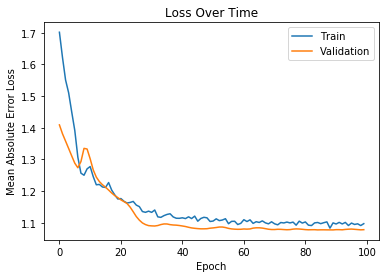

In [17]:
plt.plot(np.exp(history.history['loss']))
plt.plot(np.exp(history.history['val_loss']))

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Validation']);

In [23]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,30,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

In [24]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [25]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)  
    target_series = decoder_target_data[sample_ind,:,:].reshape(-1,1)
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    #plt.figure(figsize=(10,6))   

    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps-31),target_series,color='green')
    plt.plot(range(x_encode,x_encode+pred_steps-31),pred_series[:69],color='red',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [26]:
# sp500 prediction
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=0, enc_tail_len=10)

IndexError: index 30 is out of bounds for axis 1 with size 30

In [27]:
%debug

> <ipython-input-23-4e507221b00f>(10)predict_sequence()
      8         # record next time step prediction (last time step of model output)
      9         last_step_pred = model.predict(history_sequence)[0,-1,0]
---> 10         pred_sequence[0,i,0] = last_step_pred
     11 
     12         # add the next time step prediction to the history sequence



ipdb>  last_step_pred


-0.03533025


ipdb>  %who


*** SyntaxError: invalid syntax


ipdb>  dir()


['history_sequence', 'i', 'input_sequence', 'last_step_pred', 'pred_sequence']


ipdb>  i


30


ipdb>  input_sequence


array([[[-0.23219008],
        [-0.16010535],
        [-0.17512065],
        [-0.20897004],
        [-0.17966956],
        [-0.18119047],
        [-0.1673346 ],
        [-0.10925925],
        [-0.0708197 ],
        [-0.00552896],
        [-0.0074461 ],
        [ 0.08650631],
        [ 0.15712829],
        [ 0.2171463 ],
        [ 0.23587628],
        [ 0.3216889 ],
        [ 0.41591059],
        [ 0.44304537],
        [ 0.42770891],
        [ 0.4498168 ],
        [ 0.48587107],
        [ 0.45560377],
        [ 0.28798836],
        [ 0.17380879],
        [-0.00128177],
        [-0.11660439],
        [-0.18934131],
        [-0.16010535],
        [-0.24319542],
        [-0.27055691],
        [-0.16010535],
        [-0.07880241],
        [-0.06923077],
        [-0.12041664],
        [-0.0381911 ],
        [-0.12184999],
        [-0.08040662],
        [-0.01343414],
        [-0.00467808],
        [-0.06991143],
        [-0.07263871],
        [-0.05549027],
        [-0.06290021],
        [-0

ipdb>  global()


*** SyntaxError: invalid syntax


ipdb>  globals()


{'__name__': '__main__', '__doc__': 'Automatically created module for IPython interactive environment', '__package__': None, '__loader__': None, '__spec__': None, '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '_ih': ['', "import pandas as pd\nimport numpy as np\nimport missingno as mn\nimport seaborn as sns\nimport matplotlib.pyplot as plt\nfrom datetime import timedelta\nfrom keras.models import Model\nfrom keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate\nfrom keras.optimizers import Adam\nget_ipython().run_line_magic('matplotlib', 'inline')", "# load data\nraw = pd.read_csv('../arima_fc/data/canola_oil_v2.csv')\nraw.index = pd.to_datetime(raw.date).dt.date", 'raw.head()', 'mn.matrix(raw)', 'mn.matrix(raw[raw.co.notnull()])\ndf = raw[raw.co.notnull()]', "df = df.drop('date',axis=1)\ndf.head()", 'df = df.T\ndf.head()', 'data_start_date = df.columns[1]\ndata_end_date = df.columns[-1]\n\npr

ipdb>  exit
